In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def getHomo(X, x, iterations=500, thresh=5):
    # Simliar to DLT
    maxCount = 0
    for i in range(iterations):
        idx = np.random.randint(X.shape[0], size=4)
        temp_X = X[idx]
        temp_x = x[idx]

        ax = np.concatenate((-temp_X, np.zeros((4, 3)), temp_x[:, 0:1]*temp_X), axis=1)
        ay = np.concatenate((np.zeros((4, 3)), -temp_X, temp_x[:, 1:]*temp_X), axis=1)
        M = np.concatenate((ax, ay), axis=0)
        u, s, v = np.linalg.svd(M)
        H = v[8].reshape(3, 3)
        
        tempCount = 0
        res = X.dot(H.T)
        res = np.divide(res, res[:, 2].reshape(-1, 1))
        err = np.linalg.norm(res[:, :2] - x, axis=1)
        tempCount = np.count_nonzero(err<thresh)

#         print('Random try', i+1, 'Points satisfied', tempCount)
        if tempCount > maxCount:
            bestH = H
            maxCount = tempCount
    
    return bestH
    
def keypts(im1, im2, ratio=0.4):
    
    # Calculating top 300 sift features for both the images
    sift = cv2.SIFT_create(600)
    kp1, desc1 = sift.detectAndCompute(im1, None)
    kp2, desc2 = sift.detectAndCompute(im2, None)
    
    # Finding strong matches between the 2 images using ratio testing
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    
    goodMatches = []
    for m, n in matches:
        if (m.distance/n.distance) < ratio:
            goodMatches.append(m)
    
    return kp1, kp2, goodMatches
    
def stitch(im1, im2):
    
    im1 = np.pad(im1, ((im1.shape[0], im1.shape[0]), (im1.shape[1], im1.shape[1]), (0, 0)), 'constant')
    
    # Matching points of the 2 images
    kp1, kp2, goodMatches = keypts(im1, im2)
    
    # Finding source points and destination points to compute the homography matrix
    src_pts = []
    dst_pts = []
    for i in range(len(goodMatches)):
        src_pts.append([kp2[goodMatches[i].trainIdx].pt[0], kp2[goodMatches[i].trainIdx].pt[1]])
        dst_pts.append([kp1[goodMatches[i].queryIdx].pt[0], kp1[goodMatches[i].queryIdx].pt[1]])
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    src_pts = np.concatenate((src_pts, np.ones((src_pts.shape[0], 1))), axis=1)
    
    # Computing the homography matrix and applying
    h = getHomo(src_pts, dst_pts)
    warped = cv2.warpPerspective(im2, h, (im1.shape[1], im1.shape[0]))
    
    # Creating the final image
    warped[im1!=0] = 0
    final = cleanse(warped + im1) 
    
    return final

def cleanse(im):
    for i in range(im.shape[1]-1, 0, -1):
        if (im[:, i] != 0).any():
            im = im[:, :i]
            break
            
    for i in range(0, im.shape[1]):
        if (im[:, i] != 0).any():
            im = im[:, i:]
            break
            
    for i in range(0, im.shape[0]):
        if (im[i] != 0).any():
            im = im[i:]
            break
            
    for i in range(im.shape[0]-1, 0, -1):
        if (im[i] != 0).any():
            im = im[:i]
            break
    
    return im

def findRoot(images):
    numOfFeats = []
    for i in range(len(images)):
        temp = 0
        for j in range(len(images)):
            if i != j:
                kp1, kp2, goodMatches = keypts(images[i], images[j])
                temp += len(goodMatches)
        numOfFeats.append(temp)
    
    return np.argmax(np.array(numOfFeats))

def cv2_resize(img, scale_factor):
    width = int(img.shape[1] * scale_factor)
    height = int(img.shape[0] * scale_factor)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [4]:
from pathlib import Path

data_dir = Path('/app/notebooks/image_stitching/sample_data/keyboard')
assert data_dir.exists()

In [9]:
images = []
for img_path in data_dir.iterdir():
    if img_path.suffix not in ['.jpg', '.png']:
        continue

    i_img = cv2.imread(str(img_path))
    i_img = cv2_resize(i_img, 0.5)
    images.append(i_img)

In [10]:
root = findRoot(images)

In [11]:
images[0], images[root] = images[root], images[0]

# Ordering algorithm
l = len(images)
# plt.subplot(l, 1, 1)
# plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
for i in range(l-1):
    maxLen = 0
    bestMatch = -1
    for j in range(1, len(images)):
        kp1, kp2, goodMatches = keypts(images[0], images[j])
        if len(goodMatches) > maxLen:
            maxLen = len(goodMatches)
            bestMatch = j
    
    images[0] = stitch(images[0], images[bestMatch])
    images.pop(bestMatch)
    
    # plt.subplot(l, 1, i+2)
    # plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

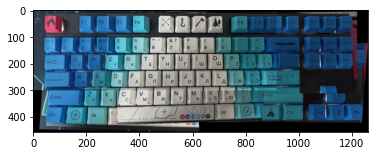

In [12]:
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [14]:
from PIL import Image

In [17]:
Image.fromarray(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)).save('stitch.png')